In [14]:
import math
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [15]:
# Constants
h = 6.626e-34  # Planck constant in J·s
c = 3.0e8      # Speed of light in m/s
kb = 1.38e-23  # Boltzmann constant in J/K

The basis of the project is the data file with opacity values at a given frequency, density, and temperature. The function below reads the file and cleans the data to be used in the program. (The data file is 250,000+ lines)

In [16]:
def get_vals(filename, n = 200):
    file = open(filename, 'r')
    file.readline()
    file.readline()


    temps = []
    for i in range(17):
        temp_line = file.readline().strip().split()
        for element in temp_line:
            temps.append(math.exp(float(element)))
    
    # print(temps)

    file.readline()

    densities = []
    for i in range(17):
        dens_line = file.readline().strip().split()
        for element in dens_line:
            densities.append(math.exp(float(element)))
        


    kappa_dict = {}
    z = int(5000/n - 1)  # read every zth frequency table
    
    for i in range(n):
        if z != 0:
            for i in range(53*z): # skip a frequency value
                file.readline()
            
        elif (random.random() > (n/5000)):
                for i in range(53): # skip a frequency value
                    file.readline()
      

        file.readline()
        file.readline()

        try: 
            f = float(file.readline().strip())
        except ValueError:
            break
        dens = {}
        for j in range(50):
            dens[densities[j]] = []
            kappas = file.readline().strip().split()
            for k in range(50):
                dens[densities[j]].append((temps[k], math.exp(float(kappas[k].replace("D", "e")))))



        kappa_dict[f] = dens


    return kappa_dict, temps, densities

Create an object for a box of gas. Serves as a 'cube' of atmosphere 

In [17]:
class Box:
    def __init__(self, n, S):
        self.S = S
        self.ds = S / n
        self.n = n

Now we want to model a black body according to Plank's Law, as represented below:

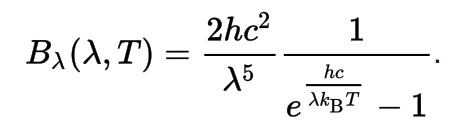

In [18]:
def black_body_radiance(frequency, temperature = 8000):
    wavelength = c / frequency
    exponent = h * c / (wavelength * kb * temperature)
    radiance = 2.0 * h * c**2 / (wavelength**5) / (np.exp(exponent) - 1)
    return radiance

The radiative transfer equation for a single direction, time-independent system is as follows:

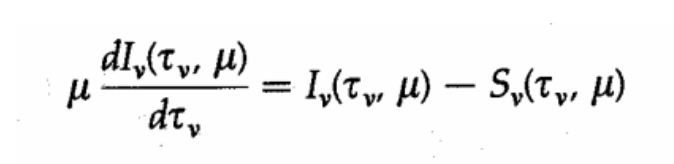

To model the radiative transfer equation, I numerically determined the result of the following equation, the general solution to the radiative transfer equation above.

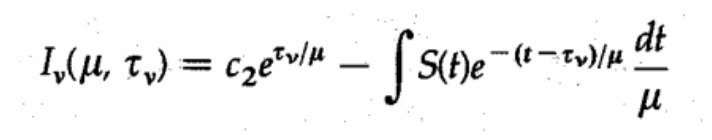

In [19]:
def rad_transfer(ts, dtao, I0, boost):
    Itot = I0 * math.exp(-ts[-1]* 10 ** boost)
#     print(Itot, file = file)
    
    for i in range(len(ts)):
        Itot += math.exp(ts[i] - ts[-1]) * I0 * dtao
    return Itot

In order to get the tao values, the optical depth values, for the function above, I used the following function to calculate tao at every interval along the box where tao = opacity * density * ds, where ds is a small movement in the direction of the light.

In [20]:
def get_tao_list(frequency, temperature, rho0, K, box, boost, density, densities, T_idx):
    # Example: Increase K and rho by a factor to see their effect

    rho = rho0
    H = temperature * 8.314 / 0.029 * 9.81

    dtao = float(K) * float(rho) * float(box.ds) * 10**(boost)
    t = [0]
    for i in range(1, box.n + 1):
        dtao = float(K) * float(rho) * float(box.ds) * 10**(boost)


        t.append(t[-1] + dtao)


        rho = atmospheric_density(i*box.ds, rho0, H) # scale height
        K = get_kappa_isothermal(rho, density, densities, T_idx)



    return t, dtao

To make the program more accurately represent an atmosphere, I incorporated a function to determine the density as a function of height, as an isothermal atmosphere. Starting with a density value given in the table for the iniial side of the box, the density values changed according to the ideal gas law as the black body moved throughout the box of gas. In this case, the density decreases exponentially with height.

In [21]:
def atmospheric_density(h, rho0, H):
    
    return rho0 * np.exp(-h / H)

As the density changes, so will the opacity value, so I created this function to extrapolate from the data file in order to obtain a more accurate oppacity for calculating tao.

In [22]:
def get_kappa_isothermal(rho, density, densities, T_idx):

    prev = 1e15
    idx = 0
    for i in range(len(densities)):
        if abs(rho - densities[i]) < prev:
            idx = i
            prev = rho - densities[i]


    temp, kappa = density[densities[i]][T_idx]

    if i == 0 or i == len(densities)-1:
        pass
    elif prev >= 0:
        kappa = (kappa + density[i+1][T_idx]) * 0.5
    else:
        kappa = (kappa + density[i-1][T_idx]) * 0.5
    

    return kappa

As the simulation ran, it became evident that there were many frequencies that were being absorbed by the gas but this effect was not significant enough to be seen on the plot. Thus, I created a boost factor to exaggerate the absorption. However, this boost factor wasn't the same as I varied the temperature I chose for the box, as some systems didn't need a boost, while others needed a small one, and some needed a large exaggeration. 

To tackle this problem, one of the largest and most time consuming problems in my project, I created a machine learning model via scikit-learn using simple techniques we learned last week to determine a value for the boost factor given a small set of data I created from observation. The model is defined as follows.

In [23]:
def train_model(X, y, model_type='', alpha=1.0):

    # Select the model type based on user input
    if model_type == 'ridge':
        model = Ridge(alpha=alpha)
    elif model_type == 'lasso':
        model = Lasso(alpha=alpha)
    else:
        model = LinearRegression()

    # Train the model
    model.fit(X, y)

    # Retrieve the model parameters
    intercept = model.intercept_
    coefficients = dict(zip(['Feature1', 'Feature2'], model.coef_))

    return model


def train_and_get_predictor(X, y):
    model = LinearRegression()
    model.fit(X, y)
    
    def get_prediction(x1, x2):
        
        return model.predict([[x1, x2]])[0]
    
    return get_prediction

Created a plotting function for data visualization to see the black body before and after shined through the box of atmospheric gas.

In [24]:
def plot(x, y, title, loglog=False):
    if loglog:
        plt.loglog(x, y)
    else:
        plt.plot(x, y)
    plt.xlabel('Frequency (f)')
    plt.ylabel('Intensity (I)')
    plt.title(title)
    plt.grid(True)
    plt.show()

Finally, run the system simulation for three different temperature and starting pressure values.

Boost: 4.370868253436138
Temperature: 695.0612700330421 K
Density: 1.9361098809878104e-08 g/cm^3


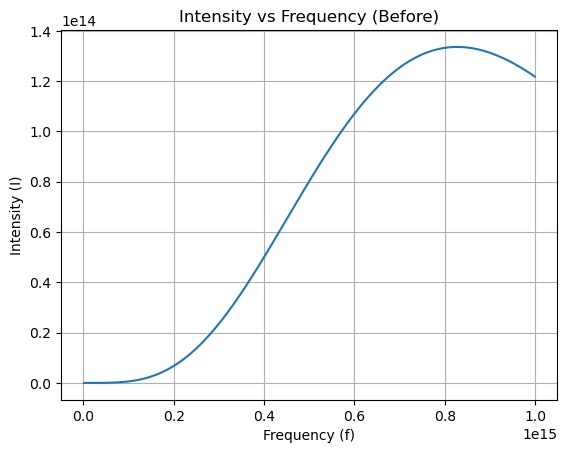

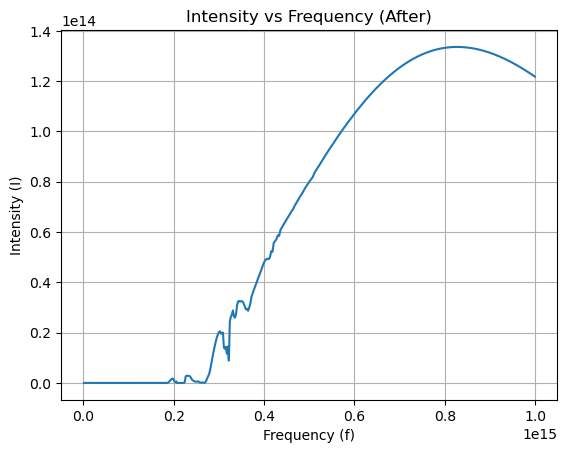

Boost: 5.013218314635648
Temperature: 2145.225598590999 K
Density: 1.6016288071967933e-12 g/cm^3


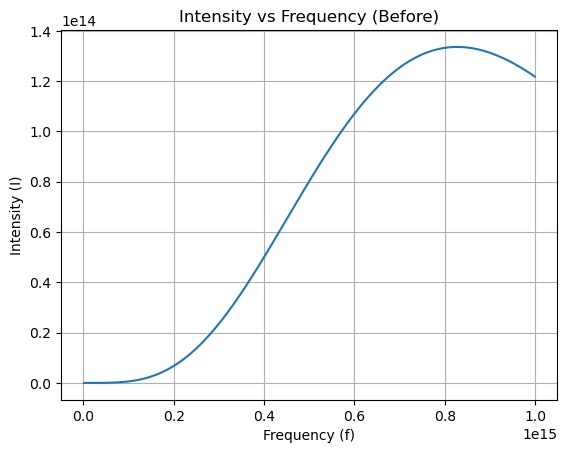

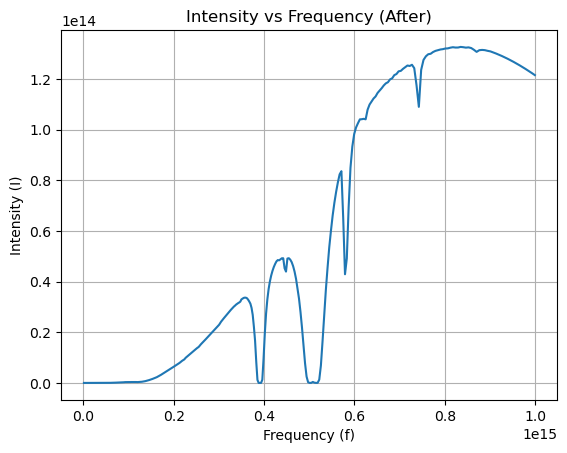

Boost: 4.541843313661134
Temperature: 1011.3081805316996 K
Density: 0.00014569429519367314 g/cm^3


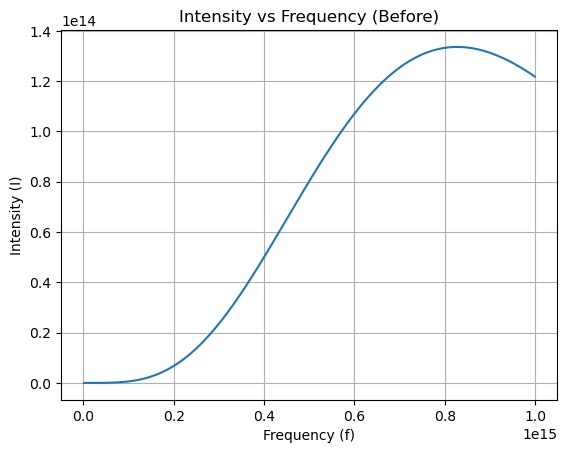

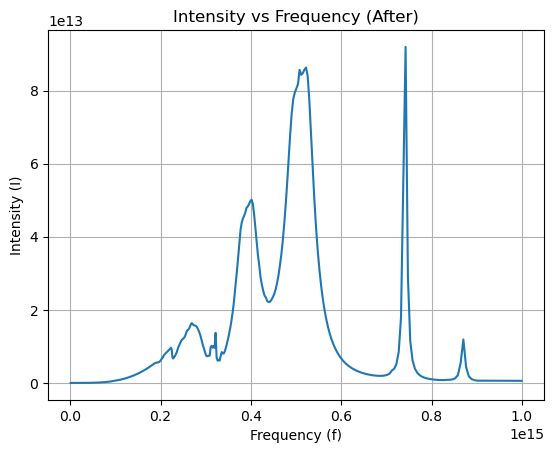

DONE


In [25]:
def run_system(T_idx, p_idx, boost, kappas, temperatures, densities):
    
    box = Box(10000, 10)
    fs, ts, Is, initial_Is, Ks = [], [], [], [], []


    for frequency, density in kappas.items():
        rho = densities[p_idx]
        temp, kappa = density[rho][T_idx]
        
        

        I0 = black_body_radiance(frequency)
        t, dtao = get_tao_list(frequency, temp, rho, kappa, box, boost, density, densities, T_idx)

        Itot = rad_transfer(t, dtao, I0, boost)
    




        fs.append(frequency)
        ts.append(t[-1])
        Is.append(Itot)
        initial_Is.append(I0)
        Ks.append(kappa)

    ws = [(3.0e8 / fi) for fi in fs]
    
    print(f"Temperature: {temp} K\nDensity: {rho} g/cm^3")
    plot(fs, initial_Is, 'Intensity vs Frequency (Before)')
    plot(fs, Is, 'Intensity vs Frequency (After)')
    

#     if T_idx < 25: 
#         plot(fs[0:int(len(fs)/1.5)], initial_Is[0:int(len(initial_Is)/1.5)], 'Intensity vs Frequency (Before)')
#     else:
#         plot(fs, initial_Is, 'Intensity vs Frequency (Before)')

#     if T_idx < 25: 
#         plot(fs[0:int(len(fs)/1.5)], Is[0:int(len(Is)/1.5)], 'Intensity vs Frequency (After)')
#     else:
#         plot(fs, Is, 'Intensity vs Frequency (After)')

    # plot(fs, Ks, 'f vs kappa')
    # # plot(fs, ts, 'Plot of f against tao values')
    # plot(fs, initial_Is, 'Intensity vs Frequency (Before)')
    # plot(fs, Is, 'Intensity vs Frequency (After)')



def main():
    idxs = [(28, 21) , (40, 1), (32, 40)]
    
    
    
    X = [
    [49, 20],
    [32, 13],
    [4, 38],
    [19, 17],
    [26, 45]
    ]

    y = [5.5, 5, 3.5, 3.3, 4]

    # Train the model and get the prediction function
    get_prediction = train_and_get_predictor(X, y)

    kappas, temperatures, densities = get_vals('.txt', 1000)

    
    for T_idx, p_idx in idxs:

        # Make a prediction
        boost = get_prediction(T_idx, p_idx)
        print("Boost:", boost)

    

        run_system(T_idx, p_idx, boost, kappas, temperatures, densities)
        

    
    
    
if __name__ == "__main__":
    main()
    print('DONE')


Image Sources:

https://ads.harvard.edu/books/1989fsa..book/AbookC10.pdf

https://en.wikipedia.org/wiki/Planck%27s_law